# Modelling 01

In this notebook I will explore different predictive models.  
First, I will create a baseline model by calculating the average of pickups per zone and per hour.  
After that, I will use some regression models to compare with the baseline model and select the best one.

### 0. [Create helper functions](#Create-helper-functions)
- [``split_data()``](#split_data())
- [``plot_real_vs_pred()``](#plot_real_vs_pred()): bar plot to visually compare real vs predicted values.
- [``get_metrics()``](#get_metrics()): it calculates relevant metrics all at once.
- [``compare_model_metrics()``](#compare_model_metrics()): bar plot to compare metrics from different models and choose the best one.

### 1. [Import dataset and select features](#Import-dataset-and-select-features)

- [Select columns of interest](#Select-columns-of-interest)
- [Separate Input and Output variables](#Separate-Input-and-Output-variables)

### 2. [Split data](#Split-data)

### 3. [Models](#Models)
#### 3.1. First approach
- [Linear Regression](#Linear-Regression)
- [K Nearest Neighbour Regressor](#K-Nearest-Neighbour-Regressor)
- [Decision Tree Regressor](#Decision-Tree-Regressor)

#### 3.2. [Second approach: using GridSearchCV](#Second-approach:-using-GridSearchCV)
- [Decision Tree Regressor_GridSearchCV](#Decision-Tree-Regressor_GridSearchCV)
- [K Nearest Neighbour Regressor_GridSearchCV](#K-Nearest-Neighbour-Regressor_GridSearchCV)

#### 3.3. [Third approach: using Bagging](#Third-approach:-using-Bagging)
- [K Nearest Neighbour Regressor_Bagging](#K-Nearest-Neighbour-Regressor_Bagging)
- [Random Forest Regressor](#Random-Forest-Regressor)
- [Random Forest Regressor_GridSearchCV](#Random-Forest-Regressor_GridSearchCV)

NOTE: Create base model. It will give us the baseline accuracy and and I should try to beat this baseline accuracy using more advanced techniques. This base model could be the average for a specific hour.

# Create helper functions

### ``split_data()``
This function will use ``sklearn.model_selection.train_test_split`` to split the data into:
- Train: 60%
- Validation: 20% (to validate training)
- Test: 20% (to validate the model)

In [1]:
def split_data(X,y):
    valSize = 0.25 #0.8 * 0.2 = 0.2
    testSize = 0.2

    # Split TRAIN-TEST
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # Split TRAIN-VALIDATION
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valSize, random_state=1)
    
    
    print('X_train: {0} ({1}%)'.format(X_train.shape[0], (X_train.shape[0]/X.shape[0])*100))
    print('y_train: {0} ({1}%)'.format(y_train.shape[0], (y_train.shape[0]/X.shape[0])*100))

    print('X_val: {0} ({1}%)'.format(X_val.shape[0], (X_val.shape[0]/X.shape[0])*100))
    print('y_val: {0} ({1}%)'.format(y_val.shape[0], (y_val.shape[0]/X.shape[0])*100))

    print('X_test: {0} ({1}%)'.format(X_test.shape[0], (X_test.shape[0]/X.shape[0])*100))
    print('y_test: {0} ({1}%)'.format(y_test.shape[0], (y_test.shape[0]/X.shape[0])*100))
    
    return X_train, X_val, X_test, y_train, y_val, y_test

### ``plot_real_vs_pred()``

This functions creates a bar plot to visually compare real vs predicted values.  

Inputs:
    - Model name
    - 'y' real values
    - 'y' predected values
Output:
    - Bar plot

In [2]:
def plot_real_vs_pred(model_name, y_real, y_pred):
    plt.style.use('ggplot')
    reg_real_vs_pred = pd.DataFrame({'Actual': y_real, 'Predicted': y_pred})
    reg_real_vs_pred = reg_real_vs_pred.head(40)
    reg_real_vs_pred.plot(kind='bar', title='MODEL: '+model_name, figsize=(16,5))
    plt.show()

### ``get_metrics()``

Function to calculate relevant metrics all at once.  

Inputs:
    - Model name
    - Real target values
    - Predected values
Outputs:
    - Model name
    - MAE
    - RMSE
    - R2
    - R (correlation)

In [3]:
def get_metrics(model_name, y_real, y_pred):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # MAE: same units as target variable. It is more robust to outliers
    MAE = mean_absolute_error(y_real, y_pred)

    # RMSE: same units as target variable
    RMSE = np.sqrt(mean_squared_error(y_real, y_pred))
    
    # R^2
    R2 = r2_score(y_real, y_pred)
    
    # Correlation
    R = np.corrcoef(y_real, y_pred)[0][1]
    
    print('MODEL: ', model_name)
    print('MAE: ', MAE)
    print('RMSE: ', RMSE)
    print('R^2 (Coefficient of determination): ', R2)
    print('R (Correlation coefficient): ', R)
    
    return model_name, MAE, RMSE, R2, R

### ``compare_model_metrics()``

Given a list of ``'model_metrics'``, obtained with the function ``get_metrics()``, this function creates several bar plots to compare metrics from different models and choose the best one.

In [4]:
def compare_model_metrics(mod_metric_list):
    
    plt.style.use('ggplot')
    # create DataFrames with metric data
    df_MAE = pd.DataFrame(columns=['MAE'])
    df_MAE_index = []
    df_RMSE = pd.DataFrame(columns=['RMSE'])
    df_RMSE_index = []
    df_R2 = pd.DataFrame(columns=['R2'])
    df_R2_index = []
    df_R = pd.DataFrame(columns=['R (Correlation)'])
    df_R_index = []
    
    for mod in mod_metric_list:
        
        df_MAE = df_MAE.append({'MAE': mod[1]}, ignore_index=True)
        df_MAE_index.append(mod[0])
        df_RMSE = df_RMSE.append({'RMSE': mod[2]}, ignore_index=True)
        df_RMSE_index.append(mod[0])
        df_R2 = df_R2.append({'R2': mod[3]}, ignore_index=True)
        df_R2_index.append(mod[0])
        df_R = df_R.append({'R (Correlation)': mod[4]}, ignore_index=True)
        df_R_index.append(mod[0])
    
    # set index names so they appear y the bar plot
    df_MAE.index = df_MAE_index
    df_RMSE.index = df_RMSE_index
    df_R2.index = df_R2_index
    df_R.index = df_R_index
    
    # sort values so the best model appears in firsst position
    df_MAE = df_MAE.sort_values('MAE', ascending=False)
    df_RMSE = df_RMSE.sort_values('RMSE', ascending=False)
    df_R2 = df_R2.sort_values('R2', ascending=True)
    df_R = df_R.sort_values('R (Correlation)', ascending=True)
    
    # create figure and one axis per metric
    f = plt.figure(figsize=(8,len(mod_metric_list*3)))
    axes1 = f.add_subplot(4,1,1)
    axes2 = f.add_subplot(4,1,2)
    axes3 = f.add_subplot(4,1,3)
    axes4 = f.add_subplot(4,1,4)
    
    # plot dataframes with DataFrame.plot()
    df_MAE.plot(kind='barh',ax=axes1, title = 'Compare Model Metrics', color='lightcoral')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_RMSE.plot(kind='barh', ax=axes2, color='cornflowerblue')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_R2.plot(kind='barh', ax=axes3, color='goldenrod')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_R.plot(kind='barh', ax=axes4, color='mediumseagreen')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    
    # annotate bars with result values 
    for p in axes1.patches:
        axes1.annotate(np.round(a=p.get_width(), decimals=1), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-30, 5), textcoords='offset points')

    for p in axes2.patches:
        axes2.annotate(np.round(a=p.get_width(), decimals=1), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-30, 5), textcoords='offset points')
    for p in axes3.patches:
        axes3.annotate(np.round(a=p.get_width(), decimals=3), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-30, 5), textcoords='offset points')

    for p in axes4.patches:
        axes4.annotate(np.round(a=p.get_width(), decimals=3), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-30, 5), textcoords='offset points')
        
    plt.show()

# Import dataset and select features

From the cleaned datasets saved from previous notebooks, I will use the one from ``2019`` and will leave the others (``2018`` and ``2017``) in case I need more training data.

In [5]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Select columns of interest

According to the conclusion from the notebook ``Data_Analysis_01.ipynb``, I will use the following columns:

- ``month``
- ``hour``
- ``week``
- ``dayofweek``
- ``isholiday``
- ``LocationID``
- ``precipitation``
- ``pickups``

In [6]:
# Import dataset
df = pd.read_csv('../data/Data_Cleaned_2019_To_Model.csv', sep=',',                 
                 dtype = {"LocationID" : "object"},
                 parse_dates=['datetime'])

# Select columns of interest
df = df[['month', 'hour', 'week', 'dayofweek', 'isholiday', 'LocationID', 'precipitation', 'pickups']]
df.info() # check dtypes
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586920 entries, 0 to 586919
Data columns (total 8 columns):
month            586920 non-null int64
hour             586920 non-null int64
week             586920 non-null int64
dayofweek        586920 non-null int64
isholiday        586920 non-null int64
LocationID       586920 non-null object
precipitation    586920 non-null float64
pickups          586920 non-null float64
dtypes: float64(2), int64(5), object(1)
memory usage: 35.8+ MB


,month,hour,week,dayofweek,isholiday,LocationID,precipitation,pickups
0,1,0,1,1,1,4,0.13,49.0
1,1,0,1,1,1,12,0.13,4.0
2,1,0,1,1,1,13,0.13,64.0
3,1,0,1,1,1,24,0.13,53.0
4,1,0,1,1,1,41,0.13,82.0


### Separate Input and Output variables

**INPUT variables**: (must be Pandas DataFrame)
- ``month``
- ``hour``
- ``week``
- ``dayofweek``
- ``isholiday``
- ``LocationID``
- ``precipitation``

**OUTPUT variable**: (must Pandas Series)
- ``pickups``

In [7]:
# Separate variables
X = df[['month','hour','week','dayofweek','isholiday','LocationID','precipitation']]
y = df['pickups']
print("FEATURES 'X' should be a Pandas DataFrame: ", type(X)) # 'X' must be DataFrame and 'y' must be a Pandas Series
display(X.head(2))
print("TARGET VARIABLE 'y' should be a Pandas Series: ",type(y))
display(y.head(2))

FEATURES 'X' should be a Pandas DataFrame:  <class 'pandas.core.frame.DataFrame'>


,month,hour,week,dayofweek,isholiday,LocationID,precipitation
0,1,0,1,1,1,4,0.13
1,1,0,1,1,1,12,0.13


TARGET VARIABLE 'y' should be a Pandas Series:  <class 'pandas.core.series.Series'>


0    49.0
1     4.0
Name: pickups, dtype: float64

# Split data

Using the custom function ``split_data()`` I get the **training**, **validation** and **test** data.

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X,y)

X_train: 352152 (60.0%)
y_train: 352152 (60.0%)
X_val: 117384 (20.0%)
y_val: 117384 (20.0%)
X_test: 117384 (20.0%)
y_test: 117384 (20.0%)


# Models

As the output variable is a number we need to solve a **regression** problem.

I will start with:
- **Linear Regression**
- **K Nearest Neighbour Regressor**
- **Decision Tree Regressor**

### Baseline model: average of pickups per zone, per hour

I will use this baseline model to compare the results with the regression models.

In [ ]:
df.head(100)

In [ ]:
basemodel = df.groupby(['hour', 'LocationID']).sum()
basemodel.sort_index()
basemodel.head(100)

date time object into unix-tipe format

In [ ]:
df.info()

## Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Create an instance of the model and train it
reg = LinearRegression()
reg.fit(X_train, y_train)

# Do predictions
reg_y_pred = reg.predict(X_val)

#### Get metrics and plot Real vs Predicted values

I can see with the graph that predictions are quite bad.

Metrics confirm this. There is a weak correlation (0.33) between real values and predictions and errors of 110-150 (MAE-RMSE) are not good enough for the scale of the pickups variable.

MODEL:  Linear Regression
MAE:  110.11816891188789
RMSE:  150.91705611228386
R^2 (Coefficient of determination):  0.1092576219241913
R (Correlation coefficient):  0.33076886258728294


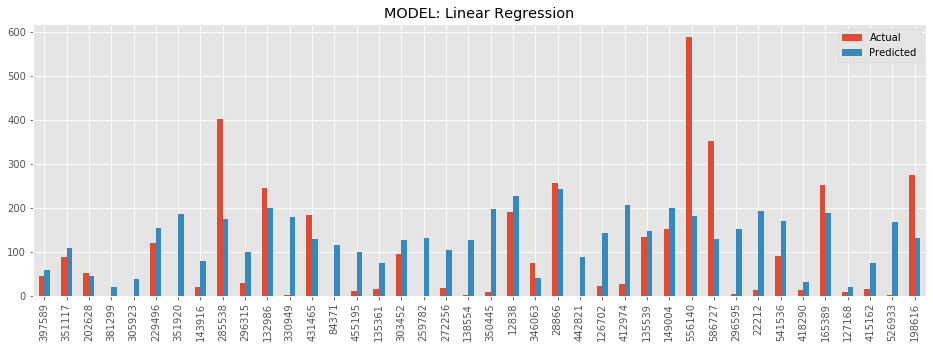

In [10]:
reg_metrics = get_metrics('Linear Regression',y_val, reg_y_pred)
plot_real_vs_pred('Linear Regression', y_val, reg_y_pred)

### K Nearest Neighbour Regressor

After a couple of iterations (trial and error) these are the parameters I found best:

- ``k = 2``  
- ``weights = 'uniform'``

In [11]:
from sklearn.neighbors import KNeighborsRegressor

# Create an instance.
regk = KNeighborsRegressor(n_neighbors=2, weights = 'uniform')

# Train the data
regk.fit(X_train, y_train)

# Do predictions
regk_y_pred = regk.predict(X_val)

#### Get metrics and plot Real vs Predicted values

There is a significant improvement with KNN. It is even noticeable in the bar plot where 'Actual' and 'Preedicted' are more similar.  
``R2`` and ``R`` show a strong correlation between real values and predicted ones.
Also, and error of 26 (``MAE``) or 50 (``RMSE``) it is relatively not that bad. In zones with and average of 300 pickups per hour may give us good predictions but in other zones with just 10-20 pickups per hour, the prediction may differ a lot from the reality.

**Conclusion**: I am happy with ``R2`` and ``R`` values. In the next models I will try to lower ``MAE`` and ``RMSE``.

MODEL:  KNN
MAE:  26.965242281741975
RMSE:  50.84534576960667
R^2 (Coefficient of determination):  0.8988937797534982
R (Correlation coefficient):  0.9484065103130591


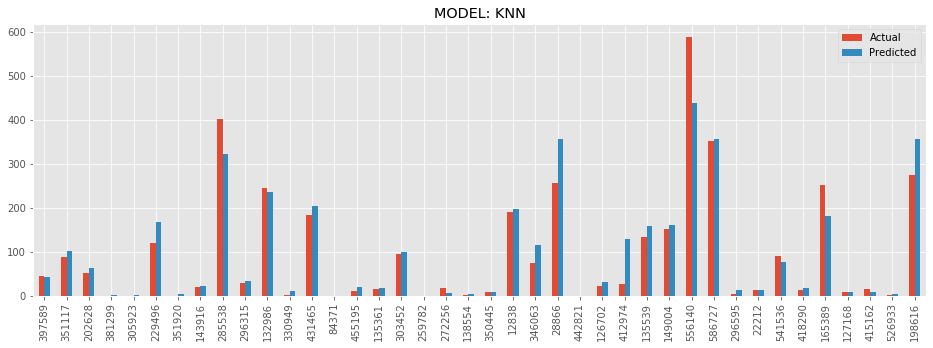

In [12]:
regk_metrics = get_metrics('KNN',y_val, regk_y_pred)
plot_real_vs_pred('KNN', y_val, regk_y_pred)

### Decision Tree Regressor

After a couple of iterations (trial and error) these are the parameters I found best:

``max_depth`` (number of splits): ``20``  
``min_samples_leaf`` (minimum number of samples for each split group): ``15``

It seems that if I increase those values the model does not improve.

In [13]:
%%time
from sklearn.tree import DecisionTreeRegressor

# Create an instance.
regd = DecisionTreeRegressor (max_depth = 20,
                              min_samples_leaf=15)

# Train the data
regd.fit(X_train, y_train)

# Do predictions
regd_y_pred = regd.predict(X_val)

#### Get metrics and plot Real vs Predicted values

There is a bit of improvement in comparison with the KNN model.  
It is not noticable in the bar plot but the metrics are better.

MODEL:  Decision Tree
MAE:  18.321750791298463
RMSE:  36.551132043235036
R^2 (Coefficient of determination):  0.9477511026752161
R (Correlation coefficient):  0.9735392205061455


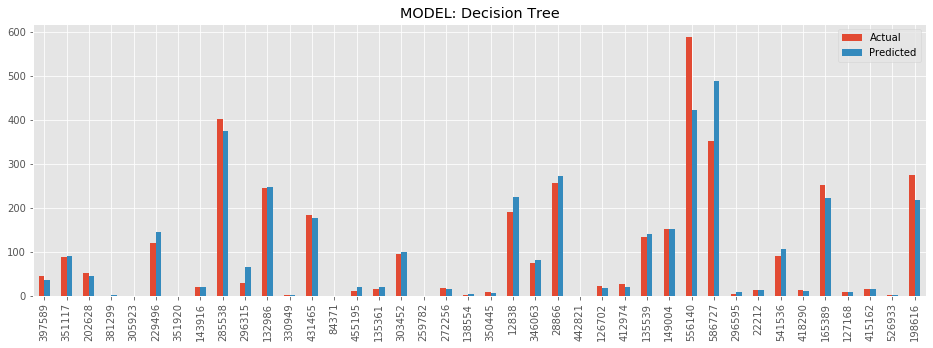

In [14]:
regd_metrics = get_metrics('Decision Tree', y_val, regd_y_pred)
plot_real_vs_pred('Decision Tree', y_val, regd_y_pred)

### Compare metrics

**Linear Regression** is the worst model, far away from the other two models. I will discard it.
**Decision Tree** beats **KNN** for a small but relevant amount.

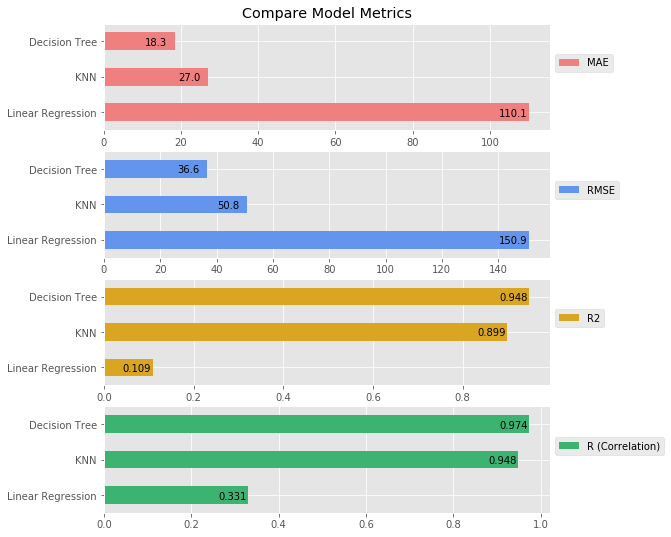

In [15]:
compare_model_metrics([reg_metrics,
                       regk_metrics,
                       regd_metrics])

# Second approach: using GridSearchCV

I will not try to improve LinearRegression as their results are very bad and far from KNN and Decision Trees

### K Nearest Neighbour Regressor_GridSearchCV

I have tried different range of values for ``n_neighbors`` (2-10) and ``leaf_size`` (15-40).
The model does not improve above those values.  
The actual values chosen by GridSearchCV are:

- ``n_neighbors = 3``
- ``leaf_size = 22``


In [16]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

regk_grid = GridSearchCV(KNeighborsRegressor(),
                       param_grid={"n_neighbors":np.arange(2,4),
                                  "leaf_size":np.arange(15,25)},
                       cv = 2,
                       scoring = "neg_mean_absolute_error")

# Train the model with the dataset
regk_grid.fit(X_train,y_train)

# Do predictions
regk_grid_y_pred = regk_grid.predict(X_val)
regk_grid.best_estimator_

CPU times: user 2min 32s, sys: 1.8 s, total: 2min 34s
Wall time: 2min 11s


KNeighborsRegressor(algorithm='auto', leaf_size=22, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [17]:
regk_grid.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=22, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

### Get metrics and Compare with previous models

GridSearchCV has improved the results of KNN but the Decision Tree model is still better.

MODEL:  KNN_GridSearchCV
MAE:  24.121725845657554
RMSE:  44.60491956455592
R^2 (Coefficient of determination):  0.9221890019262134
R (Correlation coefficient):  0.9603215863472203


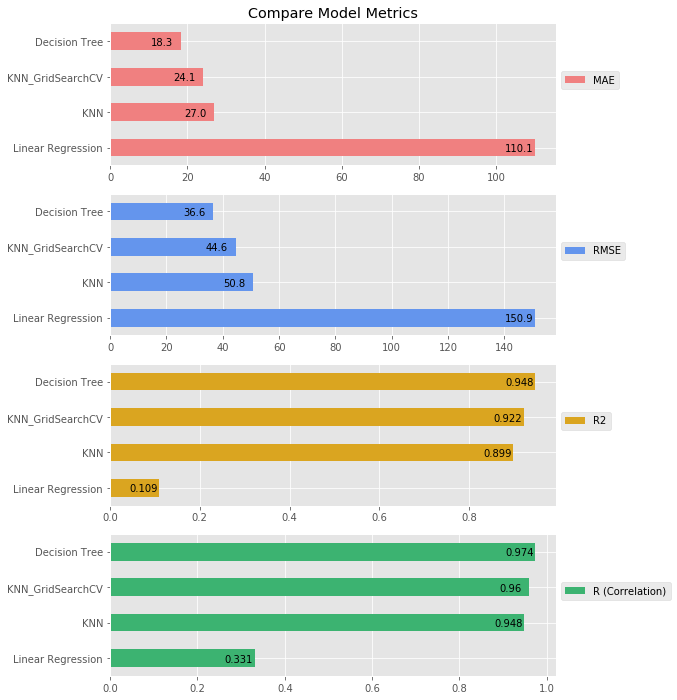

In [18]:
regk_grid_metrics = get_metrics('KNN_GridSearchCV', y_val, regk_grid_y_pred)

compare_model_metrics([reg_metrics,
                       regk_metrics,
                       regd_metrics,
                       regk_grid_metrics])

### Decision Tree Regressor_GridSearchCV

I have run ``GridSearchCV`` trying different range of values for ``max_depth`` (15-35) and ``min_samples_leaf`` (2-20).
The model does not improve above those values.  
The actual values chosen by GridSearchCV are:

- ``max_depth = 31``
- ``min_samples_leaf = 5``

In [19]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor


regd_grid = GridSearchCV(DecisionTreeRegressor(),
                       param_grid={"max_depth":np.arange(25,35),
                                  "min_samples_leaf":np.arange(2,10)},
                       cv = 2,
                       scoring = "neg_mean_absolute_error")

# Train the model with the dataset
regd_grid.fit(X_train,y_train)

# Do predictions
regd_grid_y_pred = regd_grid.predict(X_val)
regd_grid.best_estimator_

CPU times: user 1min 38s, sys: 125 ms, total: 1min 38s
Wall time: 1min 38s


DecisionTreeRegressor(criterion='mse', max_depth=27, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

### Get metrics and Compare with previous models

``GridSearchCV`` has slightly improved the previous Decision Tree model.

MODEL:  Decision Tree_GridSearchCV
MAE:  17.312460864745784
RMSE:  34.29192931432427
R^2 (Coefficient of determination):  0.9540104346977509
R (Correlation coefficient):  0.9767878199426986


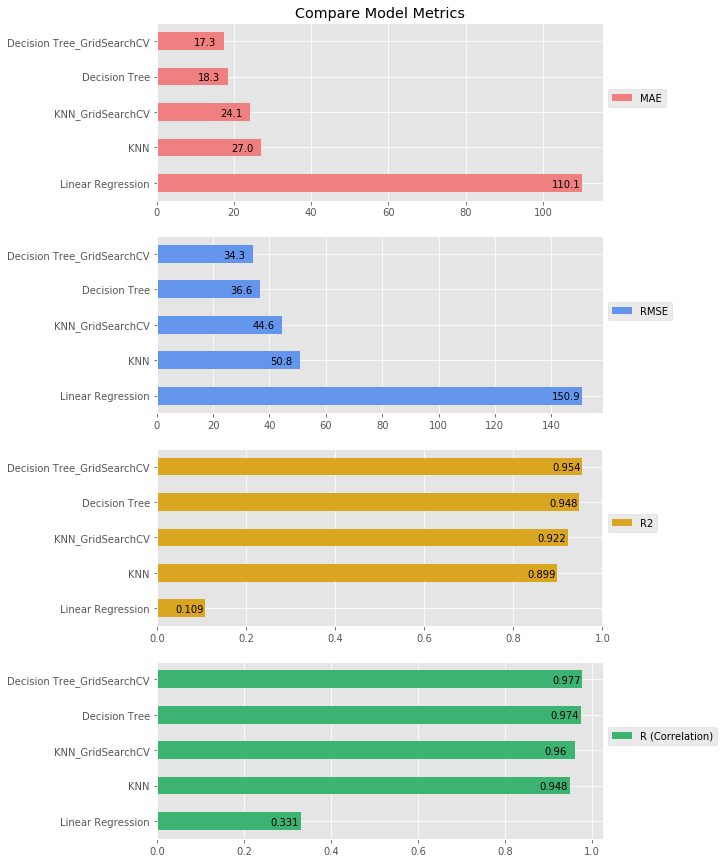

In [20]:
regd_grid_metrics = get_metrics('Decision Tree_GridSearchCV', y_val, regd_grid_y_pred)

compare_model_metrics([reg_metrics,
                       regk_metrics,
                       regd_metrics,
                       regk_grid_metrics,
                       regd_grid_metrics])

# Third approach: using Bagging

### K Nearest Neighbour Regressor_Bagging

The calculation time is many times more than GridSerachCV and the results have just improved 5%.  
Decision Tree_GridSearchCV is still the best model.

In [24]:
%%time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor

regk_bag=BaggingRegressor(base_estimator=KNeighborsRegressor(n_neighbors=3),
                          n_estimators=100,oob_score=False)

# Train the model
regk_bag.fit(X_train,y_train)

CPU times: user 2min 37s, sys: 3.69 s, total: 2min 41s
Wall time: 2min 41s


BaggingRegressor(base_estimator=KNeighborsRegressor(algorithm='auto',
                                                    leaf_size=30,
                                                    metric='minkowski',
                                                    metric_params=None,
                                                    n_jobs=None, n_neighbors=3,
                                                    p=2, weights='uniform'),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=100, n_jobs=None,
                 oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [25]:
%%time
# Do predictions
regk_bag_y_pred = regk_bag.predict(X_val)

CPU times: user 5min 27s, sys: 3.8 s, total: 5min 31s
Wall time: 4min 35s


### Get metrics and Compare with previous models

``BaggingRegressor`` has slightly improved the previous KNN model with ``GridSearchCV``.

MODEL:  KNN_Bagging
MAE:  22.89534235216611
RMSE:  42.06080411963662
R^2 (Coefficient of determination):  0.930812026966918
R (Correlation coefficient):  0.9649900718264173


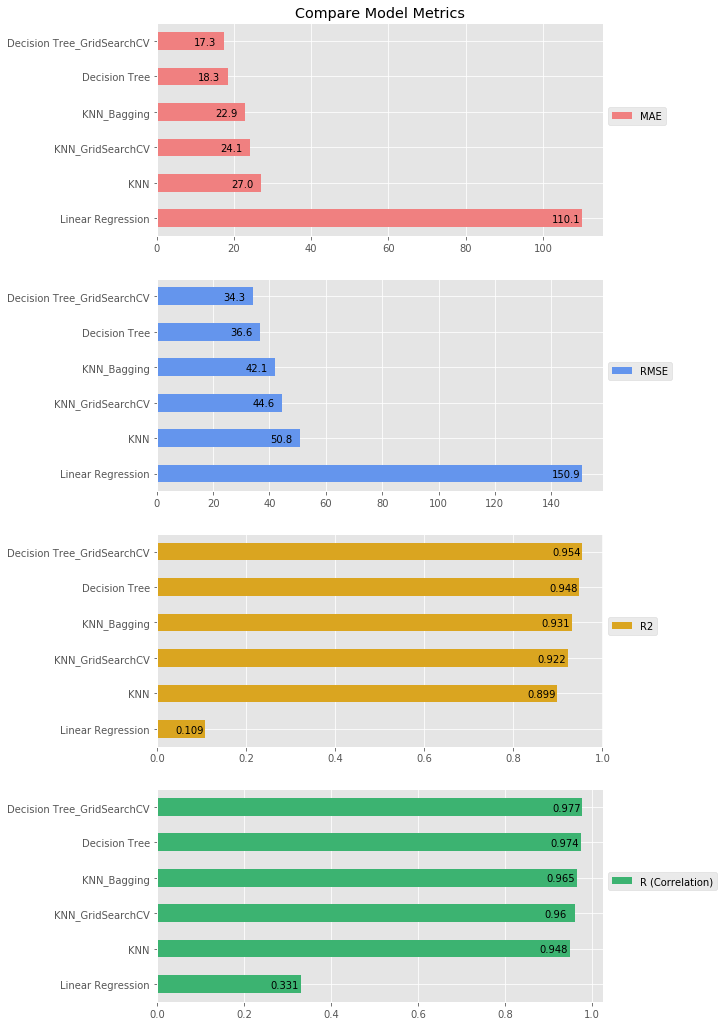

In [29]:
regk_bag_metrics = get_metrics('KNN_Bagging', y_val, regk_bag_y_pred)

compare_model_metrics([reg_metrics, 
                       regk_metrics, 
                       regd_metrics, 
                       regk_grid_metrics, 
                       regd_grid_metrics,
                       regk_bag_metrics])

### Random Forest Regressor

In [41]:
%%time
from sklearn.ensemble import RandomForestRegressor

# n_jobs: to specify how many concurrent processes/threads should be used. For -1, all CPUs are used.
regrf = RandomForestRegressor(max_depth=31,
                              min_samples_leaf=5,
                              n_estimators=50,
                              n_jobs=-1)
                            
# Train the mdoel
regrf.fit(X_train,y_train)

# Do predictions
regrf_y_pred = regrf.predict(X_val)
regrf.base_estimator

CPU times: user 1min 14s, sys: 562 ms, total: 1min 15s
Wall time: 10.5 s


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

#### Get metrics and Compare with previous models

``BaggingRegressor`` has slightly improved the previous KNN model with ``GridSearchCV``.

MODEL:  Random Forest
MAE:  15.839148345063188
RMSE:  31.632158176477894
R^2 (Coefficient of determination):  0.9608679038241493
R (Correlation coefficient):  0.9802397899994727


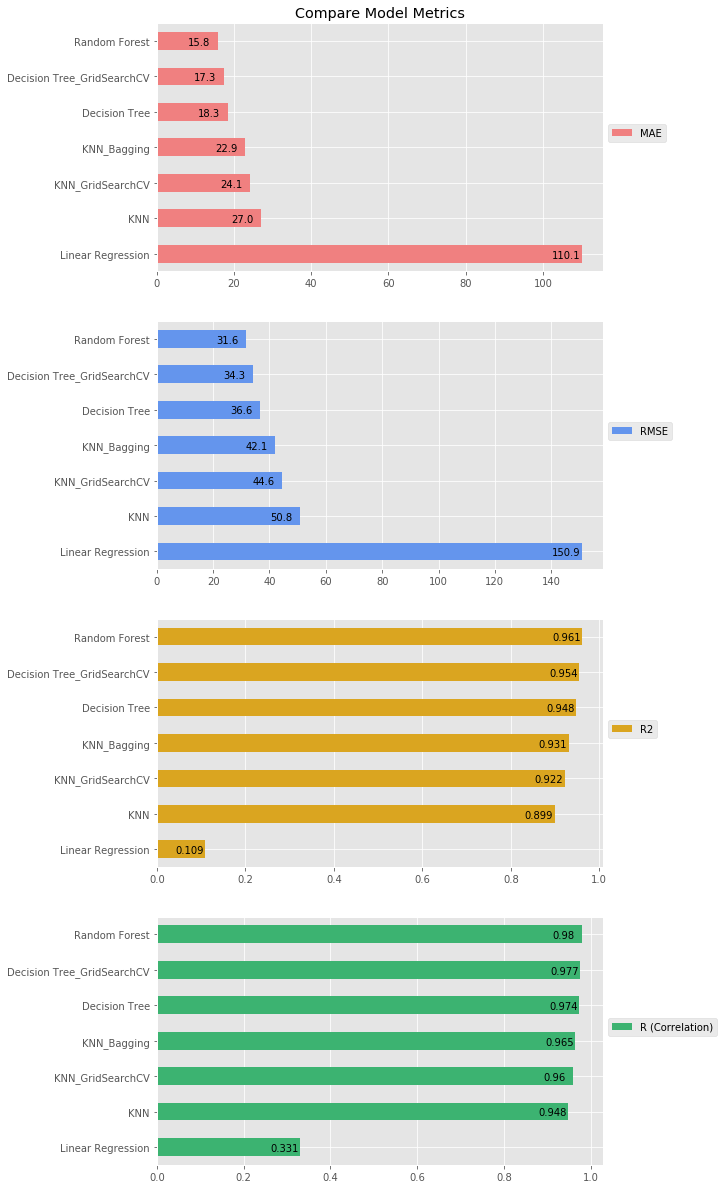

In [42]:
regrf_metrics = get_metrics('Random Forest', y_val, regrf_y_pred)

compare_model_metrics([reg_metrics, 
                       regk_metrics, 
                       regd_metrics, 
                       regk_grid_metrics, 
                       regd_grid_metrics,
                       regk_bag_metrics,
                       regrf_metrics])

### Random Forest Regressor_RandomizedSearchCV

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


regrf_rscv= RandomizedSearchCV(RandomForestRegressor(),
                       param_distributions={"max_depth":np.arange(25,35),
                                  "min_samples_leaf":np.arange(2,10),
                                  "n_estimators": (10,50,100,500)},
                       cv = 3,
                       scoring = "neg_mean_absolute_error",
                       n_iter=5)

# Train the model with the dataset
regrf_rscv.fit(X_train,y_train)

In [53]:
%%time
# Do predictions
regrf_rscv_y_pred = regrf_rscv.predict(X_val)
regrf_rscv.best_estimator_

CPU times: user 1.33 s, sys: 0 ns, total: 1.33 s
Wall time: 1.31 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=7, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

MODEL:  Random Forest_RandomizedSearchCV
MAE:  23.64306562265528
RMSE:  43.64481593537365
R^2 (Coefficient of determination):  0.9255026546266184
R (Correlation coefficient):  0.9620681029463517


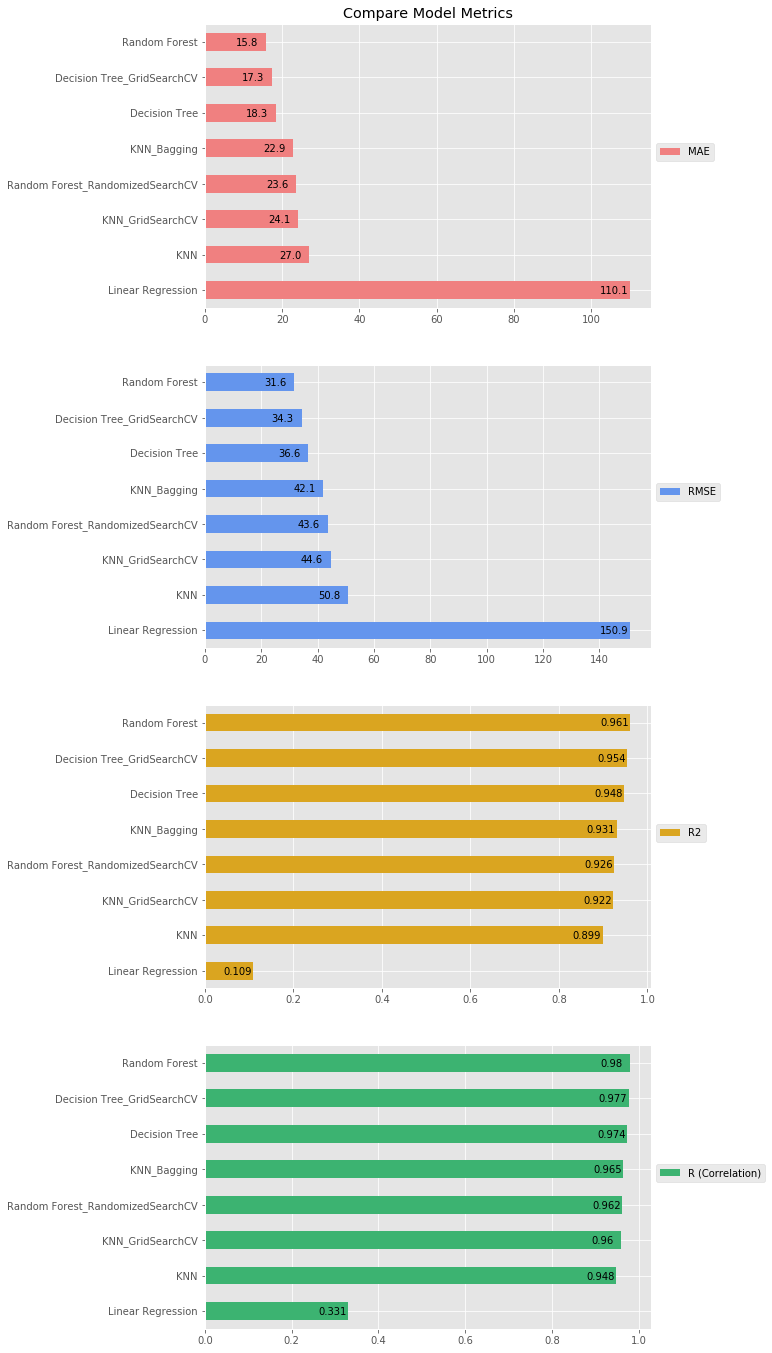

In [54]:
regrf_rscv_metrics = get_metrics('Random Forest_RandomizedSearchCV',
                                 y_val, regrf_rscv_y_pred)

compare_model_metrics([reg_metrics, 
                       regk_metrics, 
                       regd_metrics, 
                       regk_grid_metrics, 
                       regd_grid_metrics,
                       regk_bag_metrics,
                       regrf_metrics,
                       regrf_rscv_metrics])

# Gradient Boosting Regressor

# Lasso y Ridge

Modelos de gridsearch se usa ``modelo.best_params_``

## Pack model with Pickle

In [ ]:
import pickle
pickle.dump(reg,open('./model_reg_01.pickle','wb'))